# BASIC CONFIGURATIONS

In [1]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None

In [2]:
# ONLY RUN ONCE!
# Defining root
root =  devBoard.Root(   
        top_level  = rootTopLevel,
        dev        = '/dev/datadev_0',
        pollEn     = False,
        initRead   = True,
        serverPort = 9099)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000000
UpTime       = 3 days, 4:36:28
GitHash      = 0x7c10da3f839dad9db1993b2288affa4aeac5f726
XilinxDnaId  = 0x400200000139d7204c80e045
FwTarget     = ePixHRM320k
BuildEnv     = Vivado v2022.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Fri 28 Jul 2023 08:10:59 AM PDT
Builder      = dnajjar
###################################################


In [3]:
#Run this from a teminal in your localhost without the (!). If you run it here, it will open on rdsrv314 Jupyter server terminal and you won't see it.
#!python -m pyrogue gui --server='rdsrv314:9099'

In [3]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]

In [4]:
# Set & Read ScratchPad
print(hex(AXIV.ScratchPad.get()))
AXIV.ScratchPad.set(0xdeadbeef)
print(hex(AXIV.ScratchPad.get()))

0xdeadbeef
0xdeadbeef


In [5]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([3,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Root.Core.Si5345Pll.LoadCsvFile(): /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/EPixHRM320KPllConfig168Mhz.csv
Loaded. Waiting for lock...
Loading supply configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_RegisterControl.yml
Loading packet registers
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k/software/noteb

# Helper functions

In [6]:
def enableAllAsics(enable) :
    BATCHER0.Blowoff.set(not enable)
    BATCHER1.Blowoff.set(not enable)
    BATCHER2.Blowoff.set(not enable)
    BATCHER3.Blowoff.set(not enable)

In [7]:
def enableAsic(batcherIndex, enable) :
    getattr(root.App.AsicTop, f"BatcherEventBuilder{batcherIndex}").Blowoff.set(not enable)

In [8]:
# Helper functions

def disableAndCleanAllFullRateDataRcv() :
    FULLRATERCV0.cleanData()
    FULLRATERCV1.cleanData()
    FULLRATERCV2.cleanData()
    FULLRATERCV3.cleanData()
    FULLRATERCV0.RxEnable.set(False)
    FULLRATERCV1.RxEnable.set(False)
    FULLRATERCV2.RxEnable.set(False)
    FULLRATERCV3.RxEnable.set(False)

def enableFullRateDataRcv(index, enable) :
    getattr(root, f"fullRateDataReceiver[{index}]").RxEnable.set(enable)
    
    
def enableDataRcv(enable) :
    DATARCV0.RxEnable.set(enable)
    DATARCV1.RxEnable.set(enable)
    DATARCV2.RxEnable.set(enable)
    DATARCV3.RxEnable.set(enable)

def enableFullRateDataRcv(index, enable) :
    getattr(root, f"fullRateDataReceiver[{index}]").RxEnable.set(enable)

# Disable full rate receivers for now

In [20]:
disableAndCleanAllFullRateDataRcv()
enableDataRcv(False)

# Single image acquire example

In [22]:
enableAllAsics(True)
enableDataRcv(False)
#run some triggers and exercise lanes and locks
print("Before Trigger: {}".format(root.App.AsicTop.TriggerRegisters.AcqCount.get()))
for asicIndex in range(100):
    root.Trigger()
    time.sleep(0.01)
print("After Trigger:  {}".format(root.App.AsicTop.TriggerRegisters.AcqCount.get()))

Before Trigger: 8300
After Trigger:  8400


In [23]:
#get locked lanes
for asicIndex in range(4) : 
    root.App.SspMonGrp[asicIndex].enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, root.App.SspMonGrp[asicIndex].Locked.get()))

ASIC0: 0xffffff
ASIC1: 0xfffffe
ASIC2: 0x36ffff
ASIC3: 0xffffff


In [24]:
#Disabled lanes in ASICS
for asicIndex in range(4) : 
    root.App.AsicTop.DigAsicStrmRegisters0.enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").DisableLane.get()))


ASIC0: 0x100
ASIC1: 0x1
ASIC2: 0xc90000
ASIC3: 0x0


In [27]:
#check current frames in receivers
for asicIndex in range(4):
    print("Checkpoint: DataReceiver {} has {} frames".format(asicIndex, getattr(root, f"DataReceiver{asicIndex}").FrameCount.get()))

Checkpoint: DataReceiver 0 has 102 frames
Checkpoint: DataReceiver 1 has 150 frames
Checkpoint: DataReceiver 2 has 138 frames
Checkpoint: DataReceiver 3 has 147 frames


In [26]:
#Enable data receivers and run some triggers
enableDataRcv(True)
root.Trigger()


In [28]:
# Obtain descrambled single frame data from ASICs from DataReceiver. Data receiver is down sampled.
frame = [None for i in range(4)]
for asicIndex in range(4):
    frame[asicIndex] = getattr(root, f"DataReceiver{asicIndex}").Data.get()

print(frame)

[array([[21779, 22094, 21282, ..., 20802, 21757, 21911],
       [22108, 22184, 20908, ..., 20905, 21884, 21943],
       [21873, 21920, 21197, ..., 21142, 21808, 21732],
       ...,
       [20905, 21983, 21094, ..., 21858, 21806, 22423],
       [20558, 21775, 21288, ..., 21735, 21907, 22859],
       [20635, 21996, 21434, ..., 21506, 22288, 22503]]), array([[    0,     0,     0, ..., 20755, 21595, 21243],
       [    0,     0,     0, ..., 20843, 21528, 21213],
       [    0,     0,     0, ..., 21007, 21783, 20975],
       ...,
       [20508, 21534, 20907, ..., 22923, 21906, 22346],
       [20160, 21480, 21067, ..., 22512, 21798, 22466],
       [19766, 21318, 21021, ..., 22823, 22197, 21928]]), array([[21518, 21859, 21686, ..., 23470, 24533, 23712],
       [21614, 22037, 21732, ..., 23492, 24762, 23561],
       [21092, 21782, 21479, ..., 23385, 24449, 23598],
       ...,
       [17083, 17955, 17826, ...,    23,    23,    23],
       [17546, 18064, 18536, ...,    23,    23,    23],
       

In [29]:
#frame dimensions
for asicIndex in range(4):
    print(np.shape(frame[asicIndex]))

(192, 384)
(192, 384)
(192, 384)
(192, 384)


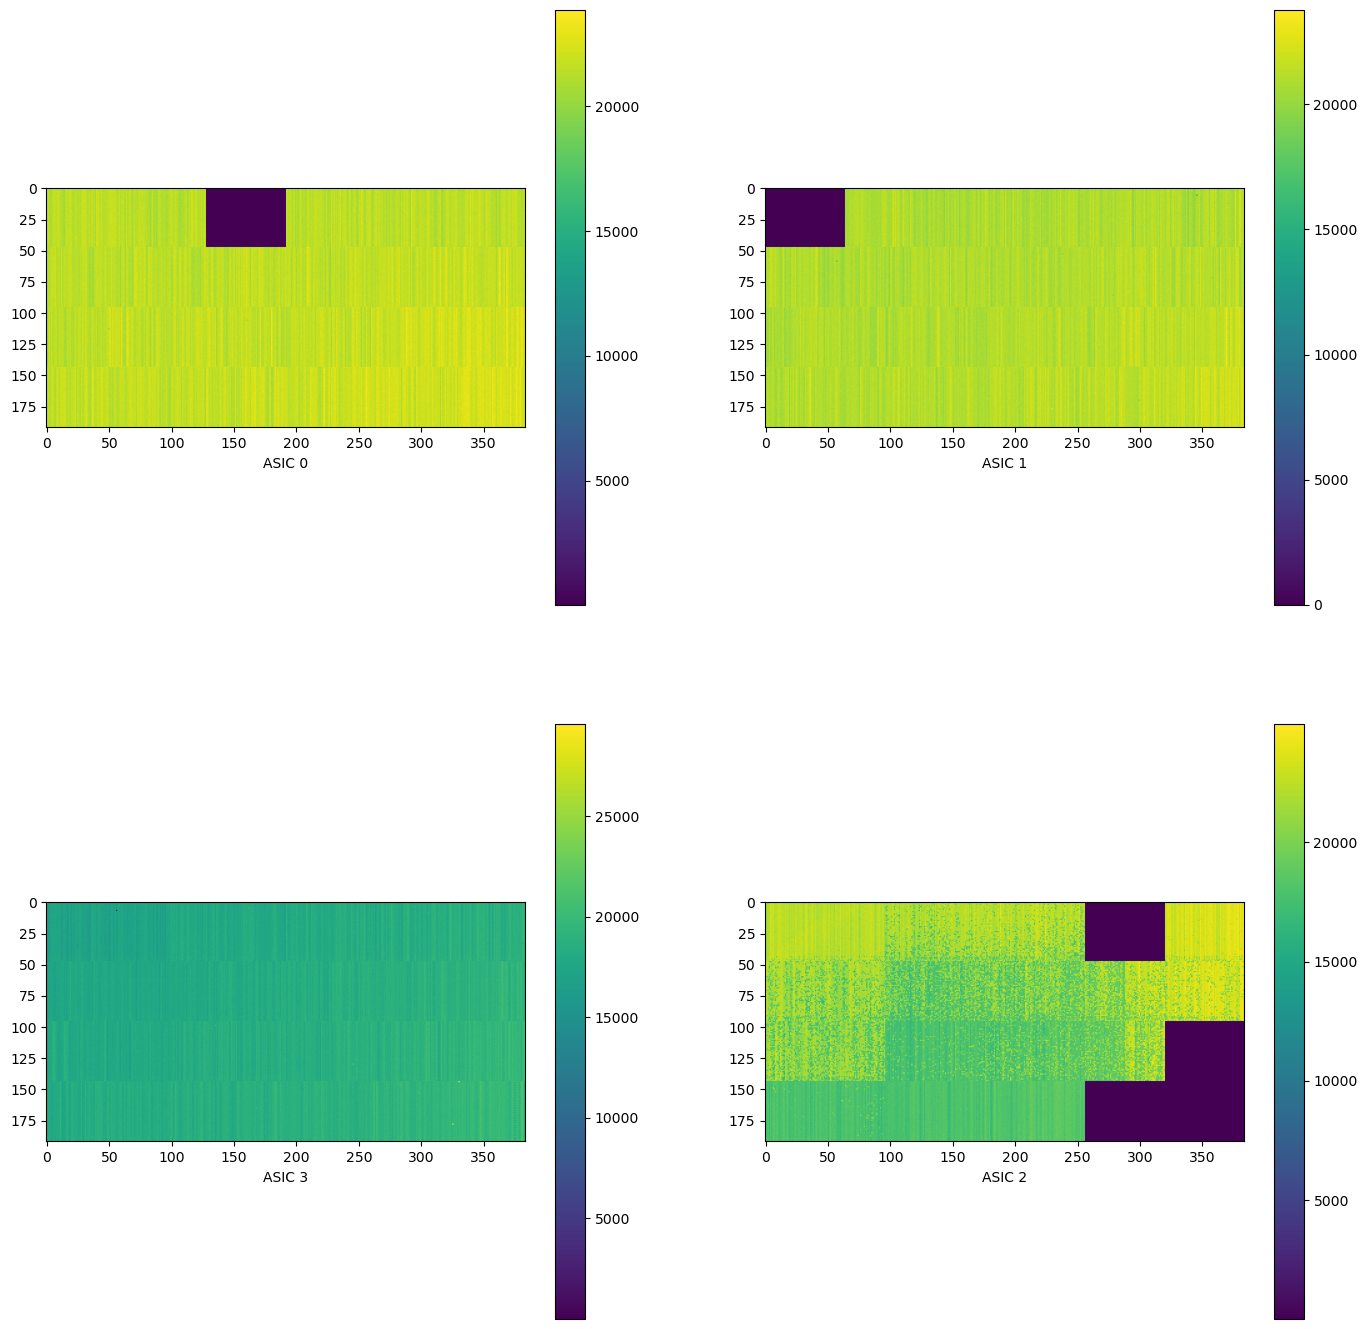

In [30]:
#plot image
plt.subplots(2,2,figsize=(17,17))
for asicIndex in range(4):
    if asicIndex == 3 :
        plt.subplot(2,2,3)
    elif asicIndex == 2 :
        plt.subplot(2,2,4)
    else :
        plt.subplot(2,2,asicIndex+1)
    
    if np.shape(frame[asicIndex])[0] != 1 :
        plt.imshow(frame[asicIndex])
        plt.xlabel("ASIC {}".format(asicIndex))
        plt.colorbar()
    else :
        plt.xlabel("ASIC {}: No data".format(asicIndex))

In [31]:
#Manipulate ASIC register
for asicIndex in range(4) : 
    root.App.Mv2Asic[asicIndex].enable.set(True)
    root.App.Mv2Asic[asicIndex].mTest.set(True)
    root.App.Mv2Asic[asicIndex].mTest.set(False)

ASIC3.mTest.set(False)

In [ ]:
#Clean up
enableDataRcv(False)

# Full acquisition of descrambled data in numpy array example

In [34]:
# Perform descrambled acquisition using debug class without writing to file.
enableAllAsics(False)
enableAsic(3, True)
DEBUG3.enableDataDebug()
DEBUG3.cleanData()
numberOfTriggers = 100
for asicIndex in range(numberOfTriggers):
    root.Trigger()
    print("{}".format(asicIndex+1), end='\r')
    time.sleep(0.01)

In [35]:
# Although the triggers above may have finished, descrambling takes time
while ( numberOfTriggers != DEBUG3.getData().shape[2]) :
    time.sleep(0.1)
    print("Descrambled {}".format(DEBUG3.getData().shape[2]), end='\r')
print("Data Descrambled")
print(DEBUG3.getData().shape)

KeyboardInterrupt: 

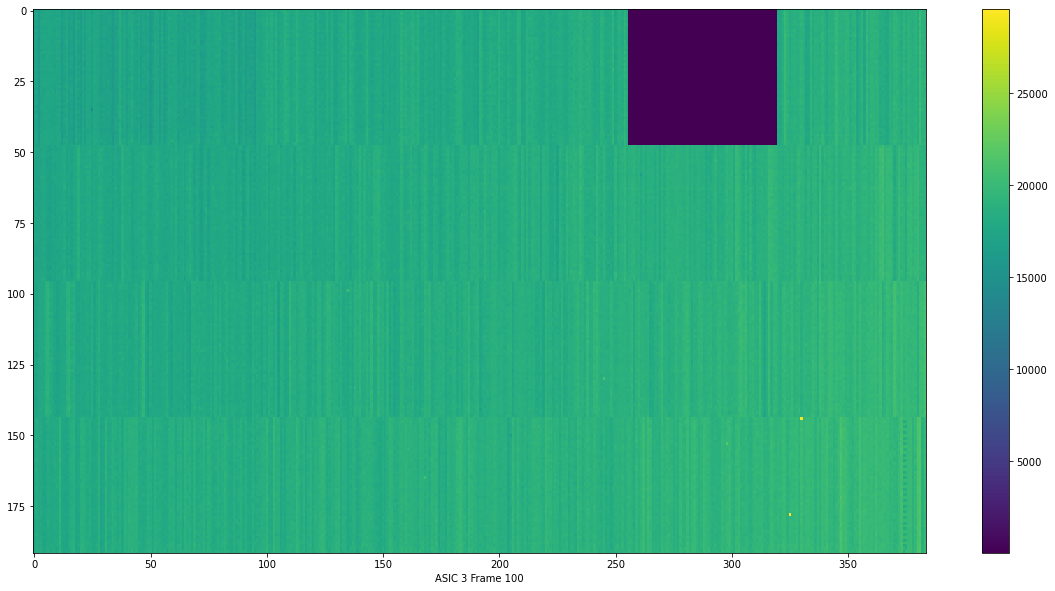

In [21]:
#Display image. Note that Interpolation is enabled. That is similar to auto contrast
plt.figure(figsize = (20,10))
plt.imshow(DEBUG3.getData()[:,:,99], interpolation='nearest', aspect='auto')
plt.xlabel("ASIC 3 Frame 100")
plt.colorbar()

In [22]:
# Disable data debug so it does not store data infinitely and crash software
DEBUG3.cleanData()
print(DEBUG3.getData().shape)
DEBUG3.disableDataDebug()

(192, 384, 0)


# Using fullRateReceiver class for acquisition with dark application

In [23]:
# Full rate reciever is slower than debug class, but it provides extra processing like applying dark
enableFullRateDataRcv(3, True)
FULLRATERCV3.cleanData()

In [24]:
# apply dark to next image
FULLRATERCV3.ApplyDark.set(False)
FULLRATERCV3.DarkReady.set(False)
FULLRATERCV3.NumDarkReq.set(1)
FULLRATERCV3.CollectDark.set(True)
while (FULLRATERCV3.DarkReady.get() == False) :
    root.Trigger()
    time.sleep(1)
FULLRATERCV3.ApplyDark.set(True)



*****Dark ready*****



In [25]:
FULLRATERCV3.cleanData()
root.Trigger()

# descrambling requires some time
while ( 1 != FULLRATERCV3.getData().shape[2]) :
    time.sleep(0.1)

print(FULLRATERCV3.getData().shape)

(192, 384, 1)


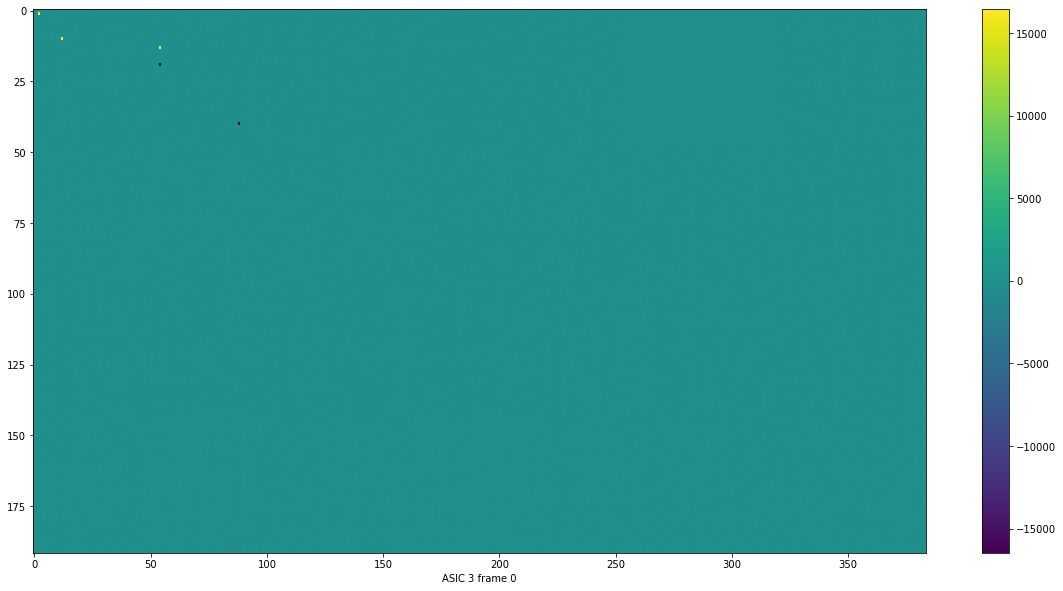

In [26]:
# Display image
plt.figure(figsize = (20,10))
plt.imshow(FULLRATERCV3.getData()[:,:,0], interpolation='nearest', aspect='auto')
plt.xlabel("ASIC 3 frame 0")
plt.colorbar()

In [27]:
# Perform descrambled acquisition using debug class without writing to file.
FULLRATERCV3.cleanData()

numberOfTriggers = 100
for asicIndex in range(numberOfTriggers):
    root.Trigger()
    print("{}".format(asicIndex+1), end='\r')
    time.sleep(0.01)

In [29]:
# Although the triggers above may have finished, descrambling takes time
while ( numberOfTriggers != FULLRATERCV3.getData().shape[2]) :
    time.sleep(0.1)
    print("Processed {}".format(FULLRATERCV3.getData().shape[2]), end='\r')
print("Data processed")
print(FULLRATERCV3.getData().shape)

KeyboardInterrupt: 

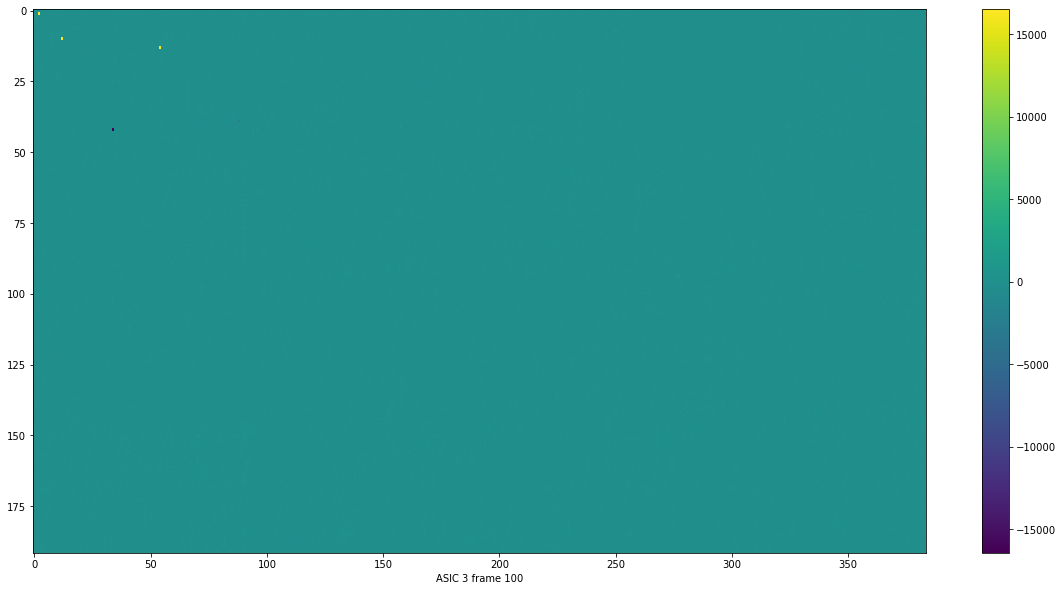

In [30]:
# Display image
plt.figure(figsize = (20,10))
plt.imshow(FULLRATERCV3.getData()[:,:,40], interpolation='nearest', aspect='auto')
plt.xlabel("ASIC 3 frame 100")
plt.colorbar()

In [23]:
# cleanup
disableAndCleanAllFullRateDataRcv()

# Using writer and converting to HDF5

In [15]:
# Set up data acquisition by writing raw to file
#
def acquireToFile(filename, frames, rate) :
    TRIG.StopTriggers()
    TRIG.AcqCountReset()
    if os.path.isfile(f'{filename}'):
        os.remove(f'{filename}')    
    print("Acquisition started: filename: {}, rate: {}, #frames:{}".format(filename, frames, rate))

    # Setup and open the file writer
    writer = root.dataWriter._writer
    root.dataWriter.DataFile.set("test.dat")

    root.dataWriter._open()


    # Wait for the file write to open the file
    while( writer.isOpen() is False):
        time.sleep(0.1)

    # Wait a little bit for the file to open up
    time.sleep(1.0)    

    #sets TriggerRegisters

    AcqCount = TRIG.AcqCount.get()
    print("Aquisition Counter " + str(AcqCount))
    TRIG.SetAutoTrigger(1000)
    TRIG.numberTrigger.set(frames)
    TRIG.StartAutoTrigger()


    # Wait for the file write to write the 10 waveforms
    while (TRIG.AcqCount.get() != frames) :
        print("Triggers sent: {}".format(TRIG.AcqCount.get()) , end='\r')
        time.sleep(0.1)
    print("Triggers sent: {}".format(TRIG.AcqCount.get()))
    
    # stops triggers
    TRIG.StopTriggers()

    writerFrameCount = writer.getFrameCount()
    for i in range(20):
        if (writerFrameCount == frames) :
            break
        time.sleep(1)
        writerFrameCount = writer.getFrameCount()
        print("Frames saved: {}".format(writerFrameCount) , end='\r')

          
        
    # Close the file writer
    writer.close()
    
    print("\n waiting for file to close...")
    # Wait for the file write to close the file
    while( writer.isOpen() is True):
        time.sleep(0.1)

    # Print the status
    print( f'Total triggers sent: {TRIG.AcqCount.get()}')
    print("File closed. Acquisition complete. Frames acquired: {}".format(writer.getFrameCount()))

In [6]:
ls *.dat

data_20230726_133618.dat  data_20230727_123339.dat  wawawiya.dat
data_20230726_135913.dat  data_20230727_183040.dat
data_20230726_142756.dat  test.dat


In [17]:
enableDataRcv(False)
disableAndCleanAllFullRateDataRcv()
enableAllAsics(False)
enableAsic(0, True)

filename = "test.dat"
rate = 1000 # HZ
frames = 1000
acquireToFile(filename, frames, rate)

Stop Triggers command executed
Acquisition started: filename: test.dat, rate: 1000, #frames:1000
Aquisition Counter 0
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 1000
Stop Triggers command executed
Frames saved: 1
 waiting for file to close...
Total triggers sent: 1000
File closed. Acquisition complete. Frames acquired: 1


In [17]:
"""
CONVERT: DAT TO HDF5
"""
# --- FAST MULTI-CORE METHOD --- #
# Note: For 130k frames at x20 cores, takes ~1.5 hours
DAT_to_HDF5 = '{}/imgProc/read_image_from_file_ePixMHrv2.py'.format(rootTopLevel)
print('Waiting... runing in process... when * changes to a number then done')
%run {DAT_to_HDF5} {filename} {"--cores=10"}
print("HDF5 generation complete")

Waiting... runing in process... when * changes to a number then done
Starting to get data set 0
Message

file: <_io.BufferedReader name='test.dat'>

size [  122644 33554434] previous size [  147508 16777218]
numberOfFrames read:  42
Message

file: <_io.BufferedReader name='test.dat'>

size [   82612 33554434] previous size [  147508 16777218]
numberOfFrames read:  701
Message

file: <_io.BufferedReader name='test.dat'>

size [  131188 33554434] previous size [  147508 16777218]
numberOfFrames read:  880
Read 1000 frames
Camera  ePixHrMv2  selected.
numberOfFrames in the 3D array:  1000
Starting descrambling images
Starting to get data set 1
Message

file: <_io.BufferedReader name='test.dat'>

size [] previous size [  147508 33554434]
numberOfFrames read:  741
Camera  ePixHrMv2  selected.
numberOfFrames in the 3D array:  741
Starting descrambling images
Saving Hdf5
(192, 384)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.